## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

from numpy.linalg import norm

import nltk
from nltk import pos_tag
from scipy.linalg import norm, eigh
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE as tsne

from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch

import yfinance as yf

from gensim.models import word2vec


In [ ]:
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
norm_docs = True 
center_term_vectors = True 
colors = "Spectral"

In [3]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristianolsson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kristianolsson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
os.chdir('/Users/kristianolsson/Desktop/DS5001_TA/project')

## Prepare Data

In [5]:
# Import data
data = pd.read_csv('data/five-years-of-aapl-on-reddit-posts.csv')
data

,index,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,0,post,qjx7sk,2qsbv,dividends,False,1635709720,https://old.reddit.com/r/dividends/comments/qj...,self.dividends,NaN,I have created a package of dividend stocks by...,Why is AAPL included in dividend ETFs?,7
1,1,post,qjx3kk,2tsxd,aapl,False,1635709375,https://old.reddit.com/r/AAPL/comments/qjx3kk/...,self.aapl,NaN,The market has now gifted MSFT (a great but in...,why AAPL deserves $200+ and a 35+ PE,7
2,2,post,qjvocf,4430vb,ultraalgo,False,1635705252,https://old.reddit.com/r/UltraAlgo/comments/qj...,pbs.twimg.com,http://pbs.twimg.com/media/FDDEGRcXIAQ5w6c.jpg,NaN,$AAPL waiting for Buy signal on AAPL https://t...,1
3,3,post,qjvo1l,2qjfk,stocks,False,1635705230,https://old.reddit.com/r/stocks/comments/qjvo1...,self.stocks,NaN,I've got about 5.5% AAPL and 11.1% MSFT. I'm ...,Sell a few AAPL shares and buy CRM?,8
4,4,post,qjtshr,2qjfk,stocks,False,1635699740,https://old.reddit.com/r/stocks/comments/qjtsh...,self.stocks,NaN,I’m a broke college student but I have enough ...,Is $AAPL able to grow much more?,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,15478,post,5ak139,2qhhq,investing,False,1478017500,https://old.reddit.com/r/investing/comments/5a...,self.investing,NaN,I have both fidelity and Robin hood accounts. ...,How to begin trading options (AAPL),6
15479,15479,post,5aji6c,3e9l4,businessadviceteam,False,1478012148,https://old.reddit.com/r/BusinessAdviceTeam/co...,reddit.com,https://www.reddit.com/r/business/comments/5aj...,NaN,UBS Survey Shows Apple (AAPL) Strength in the ...,1
15480,15480,post,5ajc8c,2qgzg,business,False,1478010285,https://old.reddit.com/r/business/comments/5aj...,streetinsider.com,http://www.streetinsider.com/Analyst+Comments/...,NaN,UBS Survey Shows Apple (AAPL) Strength in the ...,0
15481,15481,post,5ajbyk,37mcm,stock_picks,False,1478010195,https://old.reddit.com/r/Stock_Picks/comments/...,streetinsider.com,http://www.streetinsider.com/Analyst+Comments/...,NaN,UBS Survey Shows Apple (AAPL) Strength in the ...,0


In [6]:
# Create date-time columns, drop columns, drop rows with no data and duplicates, sort values, reset index

data['post_date'] = pd.to_datetime(data['created_utc'], unit='s')
data = data[['subreddit.id', 'subreddit.name','post_date','id', 'title','selftext', 'score']]
data = data.rename(columns={'subreddit.id': 'subreddit_id', 'subreddit.name': 'subreddit_name', 'title': 'post_name', 'id': 'post_id', 'selftext': 'post_text'})
data = data[data['post_text']!='[removed]']
data = data[data['post_text']!='[deleted]']
data.dropna(subset=['post_text'], inplace=True)
data.drop_duplicates('post_text', keep='first')
data.sort_values(by=['post_date'], ascending=True, inplace=True)

In [7]:
# Subset data to posts with length > 100, score>5, then find subreddits with a post count greater than 10

data = data[data['post_text'].str.len() > 50]
data = data[data['score']>=5]
subreddits = data.groupby(['subreddit_name']).agg({'score':['mean', 'median','count']}).sort_values(by=[('score','count'),('score', 'median')], ascending=False)
subreddits = subreddits[subreddits[('score','count')]>=10]
subreddits

score             
                       mean median count
subreddit_name                          
wallstreetbets   177.132505   31.0   483
stocks            88.157895   16.0   228
options           59.572581   18.0   124
investing        137.637500   18.0    80
streetguru         6.312500    6.0    48
aapl               9.893617    9.0    47
thetagang         23.333333   12.0    39
stockmarket       58.129032   10.0    31
stock_picks       10.600000    9.0    20
smallstreetbets   35.733333   13.0    15
dividends         84.461538   46.0    13
thewallstreet     17.384615   16.0    13
daytrading        31.166667   12.0    12

In [8]:
# Subset data to subreddits that have count>10

data = data[data['subreddit_name'].isin(subreddits.index)]
data.reset_index(inplace=True, drop=True)
data

,subreddit_id,subreddit_name,post_date,post_id,post_name,post_text,score
0,2qhhq,investing,2016-11-01 16:25:00,5ak139,How to begin trading options (AAPL),I have both fidelity and Robin hood accounts. ...,6
1,2qjfk,stocks,2016-11-21 15:10:38,5e4ha7,About AAPL,I know very little about stocks and investing ...,7
2,37mcm,stock_picks,2017-01-02 08:42:22,5lkb8a,Weekly Stock Market Review: 10 Top Stock Picks...,Weekly Stock Market Review: 10 Top Stock Picks...,6
3,37mcm,stock_picks,2017-01-06 16:52:12,5meml4,Bullish on Apple: $AAPL is up more than 19% si...,$AAPL is up more than 19% since this bullish f...,10
4,2th52,wallstreetbets,2017-01-07 20:43:28,5mmnx6,It's time to massively short Apple ($AAPL),"1) Apple announces earnings January 24th, 2017...",255
...,...,...,...,...,...,...,...
1148,27n9fl,thetagang,2021-10-29 00:41:16,qi0puk,"4.5k capital, looking to run a PMCC on AAPL",I have experience selling cover calls and cash...,14
1149,2qjfk,stocks,2021-10-31 17:02:20,qjtshr,Is $AAPL able to grow much more?,I’m a broke college student but I have enough ...,162
1150,2qjfk,stocks,2021-10-31 18:33:50,qjvo1l,Sell a few AAPL shares and buy CRM?,I've got about 5.5% AAPL and 11.1% MSFT. I'm ...,8
1151,2tsxd,aapl,2021-10-31 19:42:55,qjx3kk,why AAPL deserves $200+ and a 35+ PE,The market has now gifted MSFT (a great but in...,7


In [9]:
# Example post

data.post_text[3]

'$AAPL is up more than 19% since this bullish forecast on Apple \n\nhttps://lnkd.in/gtKRcMv'

In [10]:
# Mean Post Length (after subsetting)

data['post_text'].str.len().mean()

937.8412836079792

## LIB, CORPUS, VOCAB tables 

In [11]:
# Each subreddit is a 'book'. Each post within a subreddit is a 'chapter'. Each paragraph and sentence correspond to a single post/chapter.

OHCO = ['subreddit_num','post_num','paragraph_num','sentence_num']
SUBREDDIT = OHCO[:1]
POST = OHCO[:2]
PARAGRAPH = OHCO[:3]
SENTENCE = OHCO[:4]

### LIB

In [12]:
# create LIB table

LIB = data.groupby(['subreddit_id', 'subreddit_name']).agg(num_posts=('post_name', 'count'),
                                                           mean_score=('score', 'mean'),
                                                           median_score=('score', 'median'))

LIB.sort_values(['num_posts', 'median_score'], inplace=True, ascending=False)
LIB.reset_index(inplace=True)

subreddit_descriptions = {'wallstreetbets': "Like 4chan found a Bloomberg Terminal.",
                            'stocks': "Stocks - Investing and trading for all. Welcome on /r/stocks! Don't hesitate to tell us about a ticker we should know about, market news or financial education. But please, read the sidebar rules before you post. Check out our wiki to learn more!",
                            'options': "Let's Talk About: Exchange Traded Financial Options -- Options Fundamentals -- The Greeks -- Strategies -- Current Plays and Ideas -- Q&A -- **New Traders**: See the Options Questions Safe Haven weekly thread",
                            'investing': "Lose money with friends!",
                            'streetguru': "Learn. Share. Profit. Twitter @StreetGuruHQ Instagram @StreetGuruHQ facebook.com/StreetGuruHQ https://street-guru.com/",
                            'aapl': "AAPL Stock",
                            'thetagang': "selling options We are selling options to WSB degenerates using thetagang strategies!",
                            'stockmarket': "StockMarket - Reddit's Front Page of the Stock Market. Welcome to /r/StockMarket! Our objective is to provide short and mid term trade ideas, market analysis & commentary for active traders and investors. Posts about equities, options, forex, futures, analyst upgrades & downgrades, technical and fundamental analysis, and the stock market in general are all welcome.",
                            'stock_picks': '',
                            'thewallstreet': 'TheWallStreet - MONEY NEVER SLEEPS. Welcome to /r/thewallstreet. This subreddit is intended for open discussions on all subjects related to trading on Stocks, Options, Futures, Currencies and Commodities.',
                            'smallstreetbets': "smallstreetbets. Like 4chan found $5. Ever wanted to learn how to trade options AND share your progress with people online, but you're too poor for WSB? If so, you've come to the right place.",
                            'daytrading': "Daytrading: Information for your everyday trader. Daytrading futures, forex, stocks, etc.",
                            'dividends': "Dividend Investing. A community by and for dividend growth investors. Let's make money together!"}

LIB['subreddit_description'] = LIB['subreddit_name'].map(subreddit_descriptions)
LIB['subreddit_num'] = LIB.index
LIB = LIB[['subreddit_num', 'subreddit_id', 'subreddit_name', 'subreddit_description', 'num_posts', 'mean_score', 'median_score']]

post_lengths = data.groupby('subreddit_name')['post_text'].apply(lambda x: x.str.len().mean()).reset_index()
LIB = LIB.merge(post_lengths, on='subreddit_name')
LIB.rename(columns={'post_text': 'average_post_length'}, inplace=True)

LIB

,subreddit_num,subreddit_id,subreddit_name,subreddit_description,num_posts,mean_score,median_score,average_post_length
0,0,2th52,wallstreetbets,Like 4chan found a Bloomberg Terminal.,483,177.132505,31.0,929.306418
1,1,2qjfk,stocks,Stocks - Investing and trading for all. Welcom...,228,88.157895,16.0,868.530702
2,2,2r8rv,options,Let's Talk About: Exchange Traded Financial Op...,124,59.572581,18.0,866.927419
3,3,2qhhq,investing,Lose money with friends!,80,137.637500,18.0,782.050000
4,4,2bh50e,streetguru,Learn. Share. Profit. Twitter @StreetGuruHQ In...,48,6.312500,6.0,1131.333333
5,5,2tsxd,aapl,AAPL Stock,47,9.893617,9.0,381.574468
6,6,27n9fl,thetagang,selling options We are selling options to WSB ...,39,23.333333,12.0,822.461538
7,7,2qjuv,stockmarket,StockMarket - Reddit's Front Page of the Stock...,31,58.129032,10.0,3036.580645
8,8,37mcm,stock_picks,,20,10.600000,9.0,665.000000
9,9,29phiw,smallstreetbets,smallstreetbets. Like 4chan found $5. Ever wan...,15,35.733333,13.0,1272.400000


### CORPUS

In [13]:
# create CORPUS table

paragraphs = pd.DataFrame()
for subreddit_num in LIB['subreddit_num']:
    subreddit_name = LIB['subreddit_name'][subreddit_num]
    subset = data[data['subreddit_name']==subreddit_name].copy()
    subset.sort_values(by=['post_date'], ascending=True, inplace=True)
    subset.reset_index(inplace=True)
    paragraph = subset['post_text'].str.split('\n\n', expand=True).stack().to_frame('paragraph')
    paragraph['subreddit_num'] = subreddit_num
    paragraph.index.names = ['post_num','paragraph_num']
    paragraph.reset_index(inplace=True)
    paragraph.set_index(['subreddit_num', 'post_num','paragraph_num'], inplace=True)
    paragraphs = pd.concat([paragraphs, paragraph])

sentences = paragraphs['paragraph'].str.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s+', expand=True).stack().to_frame('sentence_str')
sentences.index.names = ['subreddit_num', 'post_num', 'paragraph_num', 'sentence_num']
CORPUS = sentences['sentence_str'].str.split(expand=True).stack().to_frame('token_str')
CORPUS = CORPUS[~CORPUS['token_str'].str.contains('http')]
custom_delimiters = r'[/|*+-]'
CORPUS['token_str'] = CORPUS['token_str'].str.split(custom_delimiters)
CORPUS = CORPUS.explode('token_str')
CORPUS['token_str'] = CORPUS['token_str'].str.replace('aapl', 'apple', case=False)
CORPUS['token_str'] = CORPUS['token_str'].str.replace('apples', 'apple', case=False)
CORPUS['token_str'] = CORPUS['token_str'].str.replace("apple's", 'apple', case=False)
CORPUS['term_str'] = CORPUS.token_str.str.replace(r'\W+', '', regex=True).str.lower()
CORPUS = CORPUS[(CORPUS['term_str'] != '') & (CORPUS['term_str'].str.strip('_') != '')] 
CORPUS = CORPUS[CORPUS['term_str'].str.strip().astype(bool)]

CORPUS.index.names = ['subreddit_num', 'post_num', 'paragraph_num', 'sentence_num', 'token_num']
CORPUS.head()

token_str  \
subreddit_num post_num paragraph_num sentence_num token_num              
0             0        0             0            0                 1)   
                                                  1              Apple   
                                                  2          announces   
                                                  3           earnings   
                                                  4            January   

                                                              term_str  
subreddit_num post_num paragraph_num sentence_num token_num             
0             0        0             0            0                  1  
                                                  1              apple  
                                                  2          announces  
                                                  3           earnings  
                                                  4            january

In [14]:
# Add parts of speech to CORPUS
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

CORPUS['pos_tags'] = CORPUS['term_str'].apply(pos_tagging)

def extract_pos(pos_tags):
    pos_list = [pos[1] for pos in pos_tags]
    pos_str = ''.join(pos_list)
    return pos_str

CORPUS['pos'] = CORPUS['pos_tags'].apply(lambda x: pd.Series(extract_pos(x)))
CORPUS['pos_group'] = CORPUS.pos.str[:2]

CORPUS.drop(columns=['pos_tags'], inplace=True)
CORPUS.head()

token_str  \
subreddit_num post_num paragraph_num sentence_num token_num              
0             0        0             0            0                 1)   
                                                  1              Apple   
                                                  2          announces   
                                                  3           earnings   
                                                  4            January   

                                                              term_str  pos  \
subreddit_num post_num paragraph_num sentence_num token_num                   
0             0        0             0            0                  1   CD   
                                                  1              apple   NN   
                                                  2          announces  NNS   
                                                  3           earnings  NNS   
                                                  4            january   NN   

                                                            pos_group  
subreddit_num post_num paragraph_num sentence_num token_num            
0             0        0             0            0                CD  
                                                  1                NN  
                                                  2                NN  
                                                  3                NN  
                                                  4                NN

### VOCAB (to be built upon with DFIDF in next sections)

In [15]:
# Create VOCAB table (DFIDF added later)

VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)

sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

stemmer = PorterStemmer()
VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer.stem(x.name), 1)

VOCAB.head()

,n,p,i,max_pos,max_pos_group,stop,porter_stem
term_str,,,,,,,
0,13,0.000077,13.660587,CD,CD,0,0
00,3,0.000018,15.776065,CD,CD,0,00
001,3,0.000018,15.776065,CD,CD,0,001
0015,1,0.000006,17.361027,CD,CD,0,0015
003,1,0.000006,17.361027,CD,CD,0,003


## DERIVED TABLES

In [16]:
# Define Bag of Words and TFIDF/DFIDF functions

def bow(corpus, bag, item_type='term_str'):
    bow = corpus.groupby([bag , item_type])[item_type].count().to_frame('n')
    return bow

def tfidf(bow, tf_method='sum'):
    dtcm = bow.n.unstack(fill_value=0)

    if tf_method == 'sum':
        tf = (dtcm.T / dtcm.T.sum()).T
    elif tf_method == 'max':
        tf = (dtcm.T / dtcm.T.max()).T
    elif tf_method == 'log':
        tf = (np.log2(1 + dtcm.T)).T
    elif tf_method == 'raw':
        tf = dtcm
    elif tf_method == 'bool':
        tf = dtcm.astype('bool').astype('int')
    else:
        raise ValueError(f"'{tf_method}' is not a valid TF method.")
    
    n = dtcm.shape[0]
    df = dtcm.astype('bool').sum()
    idf = np.log2(n/df)
    tfidf = tf * idf
    dfidf = df * idf

    return tfidf, dfidf

In [17]:
# Create BOW, TFIDF DFIDF, DTM, and finish VOCAB table
CORPUS_noindex = CORPUS.reset_index()
BOW = bow(corpus=CORPUS_noindex, bag='subreddit_num')
TFIDF, DFIDF = tfidf(bow=BOW, tf_method='sum')
TFIDF_stacked = TFIDF.stack().to_frame('tfidf')
BOW = BOW.merge(TFIDF_stacked,left_index=True, right_index=True)
DTM = BOW.n.unstack(fill_value=0)

DFIDF = DFIDF.to_frame('dfidf')
VOCAB = VOCAB.merge(DFIDF, left_index=True, right_index=True)

In [18]:
# Create TFIDF_L2
#Susbet VOCAB to Nouns, Adjectives, Verbs with a DFIDF score greater than the mean DFIDF score

subset = VOCAB[VOCAB['max_pos_group'].isin(['JJ', 'VB', 'NN'])]
subset = subset[subset['dfidf']>=VOCAB['dfidf'].mean()]
TFIDF_subset = TFIDF[subset.index]
TFIDF_L2 = (TFIDF_subset.T / norm(TFIDF_subset, 2, axis=1)).T
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

### BOW

In [19]:
BOW

n     tfidf
subreddit_num term_str               
0             0           6  0.000151
              00          2  0.000080
              001         2  0.000080
              0015        1  0.000055
              006         1  0.000040
...                      ..       ...
12            yesterday   3  0.000977
              yesterdays  1  0.000846
              you         5  0.000000
              your        1  0.000071
              zone        1  0.000846

[26413 rows x 2 columns]

### DTM

In [20]:
DTM

term_str,0,00,001,0015,003,005,006,0075,009,01,...,zacks,zag,zero,zig,zim,zipcodes,zm,zone,zoom,zune
subreddit_num,,,,,,,,,,,,,,,,,,,,,
0,6,2,2,1,0,0,1,1,0,6,...,2,1,4,1,0,1,0,1,4,1
1,4,0,0,0,1,0,3,0,1,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,2,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### DFIDF

In [21]:
DFIDF

,dfidf
term_str,
0,6.801759
00,5.400879
001,5.400879
0015,3.700440
003,3.700440
...,...
zipcodes,3.700440
zm,5.400879
zone,6.892558


### TFIDF

In [22]:
TFIDF

term_str,0,00,001,0015,003,005,006,0075,009,01,...,zacks,zag,zero,zig,zim,zipcodes,zm,zone,zoom,zune
subreddit_num,,,,,,,,,,,,,,,,,,,,,
0,0.000151,0.000080,0.000080,0.000055,0.00000,0.000000,0.000040,0.000055,0.000000,0.000328,...,0.000080,0.000055,0.000101,0.000055,0.000000,0.000055,0.000000,0.000020,0.000160,0.000055
1,0.000202,0.000000,0.000000,0.000000,0.00011,0.000000,0.000241,0.000000,0.000080,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000080,0.000041,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000207,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000254,0.000000,...,0.000000,0.000000,0.000320,0.000000,0.000000,0.000000,0.000254,0.000000,0.000254,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000567,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000240,0.000000,0.000000
7,0.000237,0.000188,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000257,0.000000,0.000000,0.000096,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Reduced and Normalized TFIDF_L2

In [23]:
TFIDF_L2 

term_str,10th,15th,17th,20th,2years,5th,5years,ability,absolute,abuse,...,youtube,youve,yoy,yr,ytd,zacks,zero,zm,zone,zoom
subreddit_num,,,,,,,,,,,,,,,,,,,,,
0,0.003946,-0.000574,0.006900,0.007158,0.001689,0.006218,0.003377,0.004602,0.003574,-0.001839,...,0.013188,0.004318,0.005253,-0.009388,-0.006145,0.004183,0.004588,-0.002280,-0.002194,0.014611
1,0.007041,-0.007447,-0.001873,-0.001615,0.005332,-0.002555,0.010664,0.004872,-0.002141,-0.004601,...,-0.003994,-0.008842,0.014205,0.015494,0.011929,-0.004590,-0.006461,0.006757,0.000180,-0.002935
2,-0.004340,0.002127,-0.001873,0.010606,-0.001748,0.021887,-0.003495,0.001884,0.002954,0.003094,...,-0.003994,-0.008842,-0.008558,-0.012824,-0.006145,-0.004590,-0.006461,-0.002280,-0.004433,-0.002935
3,0.008634,-0.007447,-0.001873,-0.001615,-0.001748,-0.002555,-0.003495,-0.004355,-0.005130,-0.004601,...,0.012147,-0.008842,0.056313,-0.012824,0.055667,-0.004590,0.019488,0.018324,-0.004433,0.017670
4,-0.004340,-0.007447,-0.001873,-0.001615,-0.001748,-0.002555,-0.003495,0.019882,0.010573,-0.004601,...,0.014603,-0.008842,-0.008558,-0.012824,-0.006145,-0.004590,0.008488,-0.002280,-0.004433,-0.002935
5,-0.004340,-0.007447,-0.001873,-0.001615,-0.001748,-0.002555,-0.003495,-0.004355,-0.005130,-0.004601,...,-0.003994,-0.008842,-0.008558,-0.012824,-0.006145,-0.004590,-0.006461,-0.002280,-0.004433,-0.002935
6,-0.004340,-0.007447,-0.001873,-0.001615,-0.001748,-0.002555,-0.003495,-0.004355,0.003964,0.012713,...,-0.003994,-0.008842,-0.008558,-0.012824,-0.006145,-0.004590,-0.006461,-0.002280,0.009604,-0.002935
7,-0.004340,-0.007447,0.013704,-0.001615,0.010455,-0.002555,0.020910,0.003597,0.000022,-0.004601,...,-0.003994,-0.008842,0.001251,-0.012824,-0.006145,-0.004590,-0.006461,-0.002280,0.003519,-0.002935
8,-0.004340,0.072912,-0.001873,-0.001615,-0.001748,-0.002555,-0.003495,-0.004355,0.011833,-0.004601,...,-0.003994,-0.008842,-0.008558,-0.012824,-0.006145,-0.004590,-0.006461,-0.002280,-0.004433,-0.002935


## PCA

### PCA Components

In [24]:
# Create PCA Components

COV = TFIDF_L2.cov()
eig_vals, eig_vecs = eigh(COV)
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'
EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
EIG_VEC_PAIRS.index.names = ['term1', 'term2']
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(5).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'
COMPS

,eig_val,10th,15th,17th,20th,2years,5th,5years,ability,absolute,...,youve,yoy,yr,ytd,zacks,zero,zm,zone,zoom,exp_var
pc_id,,,,,,,,,,,,,,,,,,,,,
PC0,0.135052,-0.005739,-0.007734,-0.002949,0.004632,-0.003697,0.008976,-0.007394,-0.006108,-0.000385,...,0.034003,-0.017717,-0.020907,-0.014723,0.017074,0.002845,-0.005450,0.003509,-0.003245,16.26
PC1,0.110340,-0.003233,0.018387,-0.007321,-0.004224,-0.007125,-0.005677,-0.014250,-0.010214,-0.002840,...,-0.003768,-0.026735,0.029035,-0.017324,-0.002577,-0.008663,-0.006828,0.006186,-0.009211,13.29
PC2,0.085699,0.018171,-0.027665,-0.002838,0.000536,-0.002484,0.001287,-0.004967,0.004730,-0.002208,...,-0.006229,0.000910,0.000211,0.002940,-0.003168,0.003391,0.000833,-0.007336,0.000842,10.32
PC3,0.082078,-0.002529,0.033872,-0.001191,-0.000677,-0.001095,-0.000660,-0.002189,-0.003041,0.005974,...,0.011514,-0.004922,0.061730,-0.003129,0.005583,0.001291,-0.001228,-0.021289,-0.002062,9.88
PC4,0.080521,0.003300,0.051385,-0.000132,-0.000270,-0.000439,-0.000170,-0.000879,0.001943,0.012338,...,0.004597,-0.005742,-0.100982,-0.004813,0.002206,0.001363,-0.001809,-0.002693,-0.001936,9.70


In [25]:
# Find top 5 positive terms in PC0 and top 5 negative terms in PC1
 
top_pos_terms_pc0 = COMPS.loc[:, ~COMPS.columns.isin(['eig_val','exp_var'])].loc['PC0'].sort_values(ascending=False).head(5).index.tolist()
top_neg_terms_pc1 = COMPS.loc[:, ~COMPS.columns.isin(['eig_val','exp_var'])].loc['PC1'].sort_values(ascending=True).head(5).index.tolist()

print("Top 5 positive terms for the first component (PC0):", top_pos_terms_pc0)
print("Top 5 negative terms for the second component (PC1):", top_neg_terms_pc1)

Top 5 positive terms for the first component (PC0): ['ampnbsp', 'spreadsheet', 'iv', 'calls', 'call']
Top 5 negative terms for the second component (PC1): ['iphone', 'amp', 'calls', 'sales', 'saw']


### PCA DCM

In [26]:
# Create PCA DCM

DCM = TFIDF_L2.dot(COMPS[COV.index].T) 
DCM = LIB.join(DCM)
DCM

,subreddit_num,subreddit_id,subreddit_name,subreddit_description,num_posts,mean_score,median_score,average_post_length,PC0,PC1,PC2,PC3,PC4
0,0,2th52,wallstreetbets,Like 4chan found a Bloomberg Terminal.,483,177.132505,31.0,929.306418,0.053415,-0.418295,-0.025242,-0.077925,-0.040806
1,1,2qjfk,stocks,Stocks - Investing and trading for all. Welcom...,228,88.157895,16.0,868.530702,-0.291598,-0.462888,-0.050010,-0.060312,-0.065681
2,2,2r8rv,options,Let's Talk About: Exchange Traded Financial Op...,124,59.572581,18.0,866.927419,0.575963,-0.157420,0.063194,0.001380,0.007940
3,3,2qhhq,investing,Lose money with friends!,80,137.637500,18.0,782.050000,-0.300737,-0.235733,0.063531,-0.032226,-0.056034
4,4,2bh50e,streetguru,Learn. Share. Profit. Twitter @StreetGuruHQ In...,48,6.312500,6.0,1131.333333,-0.354889,-0.059785,0.269612,-0.061868,0.110635
5,5,2tsxd,aapl,AAPL Stock,47,9.893617,9.0,381.574468,-0.042609,0.185244,-0.340603,-0.050962,-0.065626
6,6,27n9fl,thetagang,selling options We are selling options to WSB ...,39,23.333333,12.0,822.461538,0.695150,-0.065544,0.037667,0.078286,0.007894
7,7,2qjuv,stockmarket,StockMarket - Reddit's Front Page of the Stock...,31,58.129032,10.0,3036.580645,-0.336881,-0.386743,-0.173182,-0.031416,0.014810
8,8,37mcm,stock_picks,,20,10.600000,9.0,665.000000,-0.229160,0.357500,-0.359416,0.421666,0.620412
9,9,29phiw,smallstreetbets,smallstreetbets. Like 4chan found $5. Ever wan...,15,35.733333,13.0,1272.400000,0.534502,0.005063,-0.059673,0.121491,0.048920


### PCA Loadings

In [27]:
# Create PCA Loadings 
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'
LOADINGS

pc_id,PC0,PC1,PC2,PC3,PC4
term_str,,,,,
10th,-0.005739,-0.003233,0.018171,-0.002529,0.003300
15th,-0.007734,0.018387,-0.027665,0.033872,0.051385
17th,-0.002949,-0.007321,-0.002838,-0.001191,-0.000132
20th,0.004632,-0.004224,0.000536,-0.000677,-0.000270
2years,-0.003697,-0.007125,-0.002484,-0.001095,-0.000439
...,...,...,...,...,...
zacks,0.017074,-0.002577,-0.003168,0.005583,0.002206
zero,0.002845,-0.008663,0.003391,0.001291,0.001363
zm,-0.005450,-0.006828,0.000833,-0.001228,-0.001809


### PCA Visualization 1

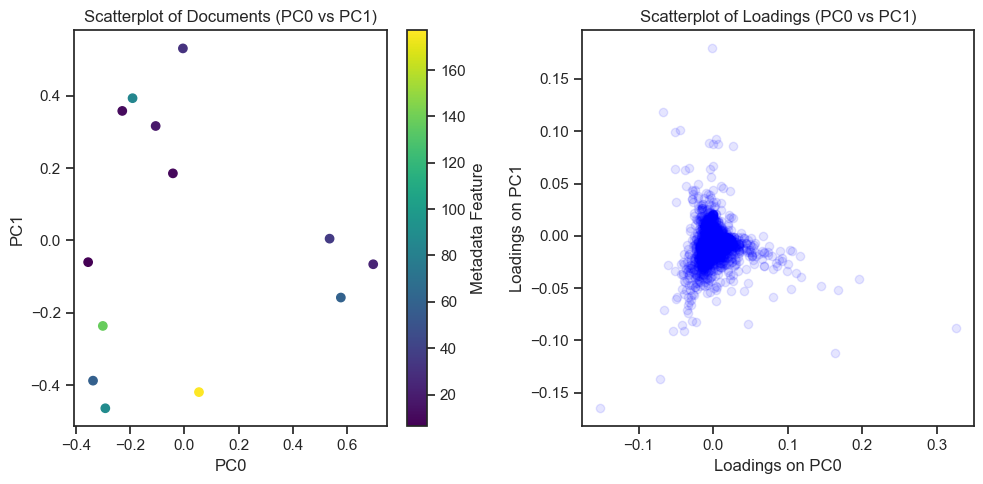

In [28]:
# Scatterplot of documents using the first two components

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(DCM['PC0'], DCM['PC1'], c=DCM['mean_score'], cmap='viridis', alpha=1)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Scatterplot of Documents (PC0 vs PC1)')
plt.colorbar(label='Metadata Feature')

plt.subplot(1, 2, 2)
plt.scatter(LOADINGS.iloc[:,0], LOADINGS.iloc[:,1], color='blue', alpha=0.1)
plt.xlabel('Loadings on PC0')
plt.ylabel('Loadings on PC1')
plt.title('Scatterplot of Loadings (PC0 vs PC1)')

plt.tight_layout()
plt.show()

### PCA Visualization 2

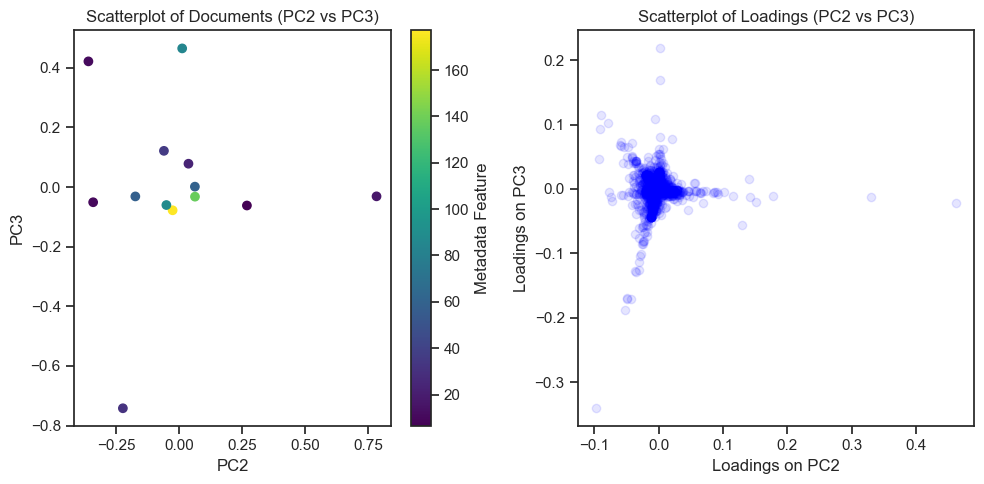

In [29]:
# Scatterplot of documents using the second two components

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(DCM['PC2'], DCM['PC3'], c=DCM['mean_score'], cmap='viridis', alpha=1)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('Scatterplot of Documents (PC2 vs PC3)')
plt.colorbar(label='Metadata Feature')

plt.subplot(1, 2, 2)
plt.scatter(LOADINGS.iloc[:,2], LOADINGS.iloc[:,3], color='blue', alpha=0.1)
plt.xlabel('Loadings on PC2')
plt.ylabel('Loadings on PC3')
plt.title('Scatterplot of Loadings (PC2 vs PC3)')

plt.tight_layout()
plt.show()

## LDA Topic Models

### LDA TOPIC

In [30]:
# Define LDA Topic Model

def topicmodel(BAG):
    BAG = BAG 

    DOCS = CORPUS[CORPUS.pos_group.str.match(r'^NN?$')]\
        .groupby(BAG).term_str\
        .apply(lambda x: ' '.join(x))\
        .to_frame()\
        .rename(columns={'term_str':'doc_str'})

    # parameters, hyperparameters
    ngram_range = (1, 2)
    n_top_terms = 5
    max_features = 1000
    stop_words = 'english'
    n_topics = 5
    max_iter = 5
    learning_offset = 50.
    random_state = 0

    # count vectorizer
    count_engine = CountVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names_out()
    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'
    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

    VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
    DOCS['term_count'] = DTM.sum(1)

    # lda
    lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=learning_offset, random_state=random_state)
    TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

    # theta
    lda_model = lda_engine.fit_transform(count_model)
    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES

    #phi
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name = 'term_str'

    #topics
    TOPICS = PHI.stack().groupby('topic_id')\
        .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
        .to_frame('top_terms')
    TOPICS['doc_weight_sum'] = THETA.sum()
    TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

    return THETA, PHI, TOPICS

In [31]:
# Create THETA, PHI, TOPICS
THETA, PHI, TOPICS = topicmodel(SUBREDDIT)

### LDA TOPIC

In [32]:
TOPICS

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T0,apple iphone market earnings stock,3.101310,0.318458
T1,apple stock market year company,4.140632,0.323132
T2,apple earnings options week stock,3.308559,0.119678
T3,table perfect averages reversal setup,0.002593,0.004293
T4,apple stock calls im earnings,2.446907,0.234438


### LDA THETA

In [33]:
THETA

,T0,T1,T2,T3,T4
subreddit_num,,,,,
0,0.560028,0.038215,0.001181,0.000011,0.400565
1,0.092351,0.871767,0.000023,0.000022,0.035837
2,0.000041,0.000041,0.526078,0.000040,0.473800
3,0.416806,0.582969,0.000076,0.000074,0.000076
4,0.999423,0.000146,0.000144,0.000142,0.000144
5,0.000251,0.000252,0.000250,0.000245,0.999003
6,0.000133,0.000133,0.999471,0.000129,0.000134
7,0.000050,0.999801,0.000050,0.000049,0.000050
8,0.000383,0.998480,0.000381,0.000373,0.000382


### LDA PHI

In [34]:
PHI

term_str,absolute,access,accessories,account,action,ad,addition,advance,advantage,advice,...,year year,years,years apple,yes,yesterday,yield,yolo,youd,youre,yoy
topic_id,,,,,,,,,,,,,,,,,,,,,
T0,6.848593,12.321712,5.183768,23.181992,7.032435,6.595562,9.354442,1.515141,8.013308,7.905264,...,6.147840,56.503860,7.050493,6.428894,34.619513,0.492489,10.954245,6.630432,19.480244,6.870278
T1,3.044524,2.990338,8.982001,25.456764,4.721233,10.453911,2.386564,10.090238,2.971897,13.044265,...,13.158813,151.313457,11.042848,8.739421,47.342963,6.301525,2.932519,1.513579,2.086841,8.351667
T2,2.416337,2.872121,0.203252,8.405522,1.958766,0.200001,0.211279,4.146531,2.890747,8.180988,...,4.133762,2.003901,0.271002,1.691471,2.986181,0.200001,0.201032,7.917400,5.140020,0.200001
T3,0.200003,0.200002,0.200001,0.200001,0.200002,0.200003,0.200002,0.200001,0.200001,0.200001,...,0.200001,0.200002,0.200002,0.200001,0.200002,0.200004,0.200001,0.200001,0.200002,0.200001
T4,2.490544,1.615828,0.430977,14.755720,13.087564,1.550524,1.847713,6.048090,5.924046,14.669482,...,5.359584,51.978780,2.435655,12.940213,17.851341,13.805982,11.712205,2.738587,26.092893,0.378053


### LDA + PCA Visualization

In [35]:
# Apply PCA to LDA PHI table

PHI_COV = PHI.cov()
eig_vals, eig_vecs = eigh(PHI_COV)
EIG_VEC = pd.DataFrame(eig_vecs, index=PHI_COV.index, columns=PHI_COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=PHI_COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'
EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
EIG_VEC_PAIRS.index.names = ['term1', 'term2']
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
PHI_COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(5).reset_index(drop=True)
PHI_COMPS.index.name = 'comp_id'
PHI_COMPS.index = ["PC{}".format(i) for i in PHI_COMPS.index.tolist()]
PHI_COMPS.index.name = 'pc_id'
PHI_COMPS

,eig_val,absolute,access,accessories,account,action,ad,addition,advance,advantage,...,years,years apple,yes,yesterday,yield,yolo,youd,youre,yoy,exp_var
pc_id,,,,,,,,,,,,,,,,,,,,,
PC0,2.846940e+05,-0.003348,-0.005158,-0.006034,-0.019347,-0.005629,-0.007397,-0.004733,-0.004370,-0.003998,...,-0.097549,-0.007926,-0.007348,-0.036286,-0.004576,-0.006783,-0.000574,-0.009583,-0.006384,80.72
PC1,3.652579e+04,0.005549,0.011152,-0.010715,-0.002562,0.014486,-0.010612,0.008343,-0.009552,0.011087,...,-0.163705,-0.010180,0.005865,-0.029127,0.004170,0.020382,0.010109,0.049714,-0.007613,10.36
PC2,2.024535e+04,-0.007256,-0.021503,-0.007018,-0.002906,0.016425,-0.007109,-0.016414,0.017445,-0.001939,...,0.055283,-0.005860,0.019090,-0.016565,0.032489,0.002195,-0.002764,0.018030,-0.011307,5.74
PC3,1.124305e+04,0.006198,0.011309,0.003634,0.014272,-0.016680,0.002186,0.000104,0.005585,0.001201,...,-0.038366,0.000937,-0.016357,-0.001818,-0.026074,-0.019545,0.025109,-0.028817,0.004064,3.19
PC4,1.750508e-15,0.000000,0.000080,0.000024,0.000168,-0.000698,-0.000198,0.000059,-0.000015,-0.000281,...,0.003974,-0.058050,0.004064,-0.000852,-0.002801,-0.026423,-0.044082,-0.007318,-0.040279,0.00


In [36]:
PHI_LOADINGS = PHI_COMPS[PHI_COV.index].T
PHI_LOADINGS.index.name = 'term_str'
PHI_LOADINGS.head()

pc_id,PC0,PC1,PC2,PC3,PC4
term_str,,,,,
absolute,-0.003348,0.005549,-0.007256,0.006198,0.000000
access,-0.005158,0.011152,-0.021503,0.011309,0.000080
accessories,-0.006034,-0.010715,-0.007018,0.003634,0.000024
account,-0.019347,-0.002562,-0.002906,0.014272,0.000168
action,-0.005629,0.014486,0.016425,-0.016680,-0.000698


In [37]:
PHI_DCM = PHI.dot(PHI_COMPS[PHI_COV.index].T) 
PHI_DCM

pc_id,PC0,PC1,PC2,PC3,PC4
topic_id,,,,,
T0,-1129.529443,270.029039,-94.795556,112.596805,0.054739
T1,-1221.616485,-178.814619,128.126663,111.950827,0.054739
T2,-276.037767,142.895327,152.444741,261.777661,0.054739
T3,-2.373242,0.482984,0.191125,1.257860,0.054739
T4,-827.067155,266.469995,272.835675,6.427226,0.054739


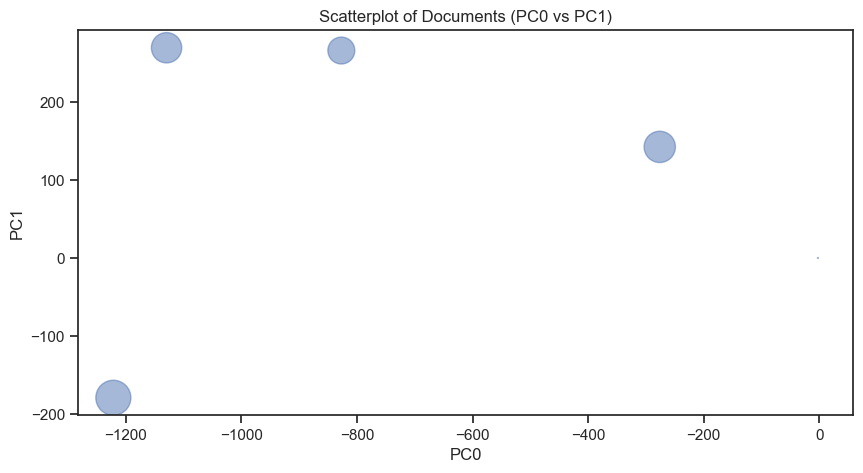

In [38]:
# Scatterplot of PCA interpretation of LDA 

mean_values = THETA.reset_index(drop=True).mean()

plt.figure(figsize=(10, 5))

# Scatterplot of documents
plt.scatter(PHI_DCM['PC0'], PHI_DCM['PC1'], s=mean_values*2000, alpha=0.5)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Scatterplot of Documents (PC0 vs PC1)')

plt.show()

## Sentiment Analysis

### Sentiment VOCAB_SENT

In [39]:
# Import NRC Emotion Lexicon

salex_csv = 'salex_nrc.csv'
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [40]:
# Combine Vocab with NRC Lexicon

VOCAB_SENT = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
VOCAB_SENT.head()

,n,p,i,max_pos,max_pos_group,stop,porter_stem,dfidf,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,
abandon,1,0.000006,17.361027,NN,NN,0,abandon,3.700440,0,0,0,1,0,1,0,1,0,0,-1
absence,1,0.000006,17.361027,NN,NN,0,absenc,3.700440,0,0,0,1,0,1,0,1,0,0,-1
abundance,1,0.000006,17.361027,NN,NN,0,abund,3.700440,0,1,1,0,1,1,1,0,0,1,0
abuse,4,0.000024,15.361027,NN,NN,0,abus,6.801759,1,0,1,1,0,1,0,1,0,0,-1
accurate,2,0.000012,16.361027,NN,NN,0,accur,5.400879,0,0,0,0,0,0,1,0,0,1,1


### Sentiment BOW_SENT

In [41]:
# Create BOW Sentiment Table

emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
BOW_SENT = BOW.join(VOCAB_SENT[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()
for col in emo_cols:
    BOW_SENT[col] = BOW_SENT[col] * BOW_SENT.tfidf
BOW_SENT.head()

n     tfidf max_pos     anger  anticipation  \
subreddit_num term_str                                                  
0             abuse       1  0.000025      NN  0.000025      0.000000   
              accurate    1  0.000040      NN  0.000000      0.000000   
              achieve     1  0.000040      NN  0.000000      0.000000   
              acquiring   3  0.000164     VBG  0.000000      0.000164   
              actionable  1  0.000040      JJ  0.000040      0.000000   

                           disgust      fear      joy   sadness  surprise  \
subreddit_num term_str                                                      
0             abuse       0.000025  0.000025  0.00000  0.000025       0.0   
              accurate    0.000000  0.000000  0.00000  0.000000       0.0   
              achieve     0.000000  0.000000  0.00004  0.000000       0.0   
              acquiring   0.000000  0.000000  0.00000  0.000000       0.0   
              actionable  0.000040  0.000000  0.00000  0.000000       0.0   

                            trust  sentiment  
subreddit_num term_str                        
0             abuse       0.00000  -0.000025  
              accurate    0.00004   0.000040  
              achieve     0.00004   0.000040  
              acquiring   0.00000   0.000164  
              actionable  0.00000  -0.000040

In [42]:
# BOW_SENT.max_pos.value_counts().sort_values().plot.barh()

### Sentiment DOC_SENT

In [43]:
# Create Aggregated Document Sentiment Table

DOC_SENT = BOW_SENT.reset_index()
DOC_SENT = DOC_SENT.groupby('subreddit_num')[emo_cols].mean()
DOC_SENT

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
subreddit_num,,,,,,,,,
0,0.000029,0.000031,0.000018,0.000027,0.000025,0.000025,0.000018,0.000034,-0.000007
1,0.000028,0.000038,0.000016,0.000032,0.000033,0.000033,0.000021,0.000052,0.000009
2,0.000067,0.000074,0.000029,0.000058,0.000046,0.000057,0.000032,0.000095,-0.000035
3,0.000067,0.000078,0.000034,0.000079,0.000064,0.000078,0.000035,0.000094,-0.000002
4,0.000072,0.000185,0.000041,0.000108,0.000120,0.000087,0.000055,0.000189,0.000132
5,0.000146,0.000149,0.000086,0.000161,0.000109,0.000185,0.000079,0.000170,-0.000140
6,0.000123,0.000139,0.000053,0.000129,0.000093,0.000112,0.000063,0.000143,-0.000072
7,0.000049,0.000067,0.000026,0.000050,0.000057,0.000054,0.000039,0.000078,0.000004
8,0.000084,0.000323,0.000062,0.000127,0.000213,0.000145,0.000062,0.000544,0.000253


### Sentiment Plot

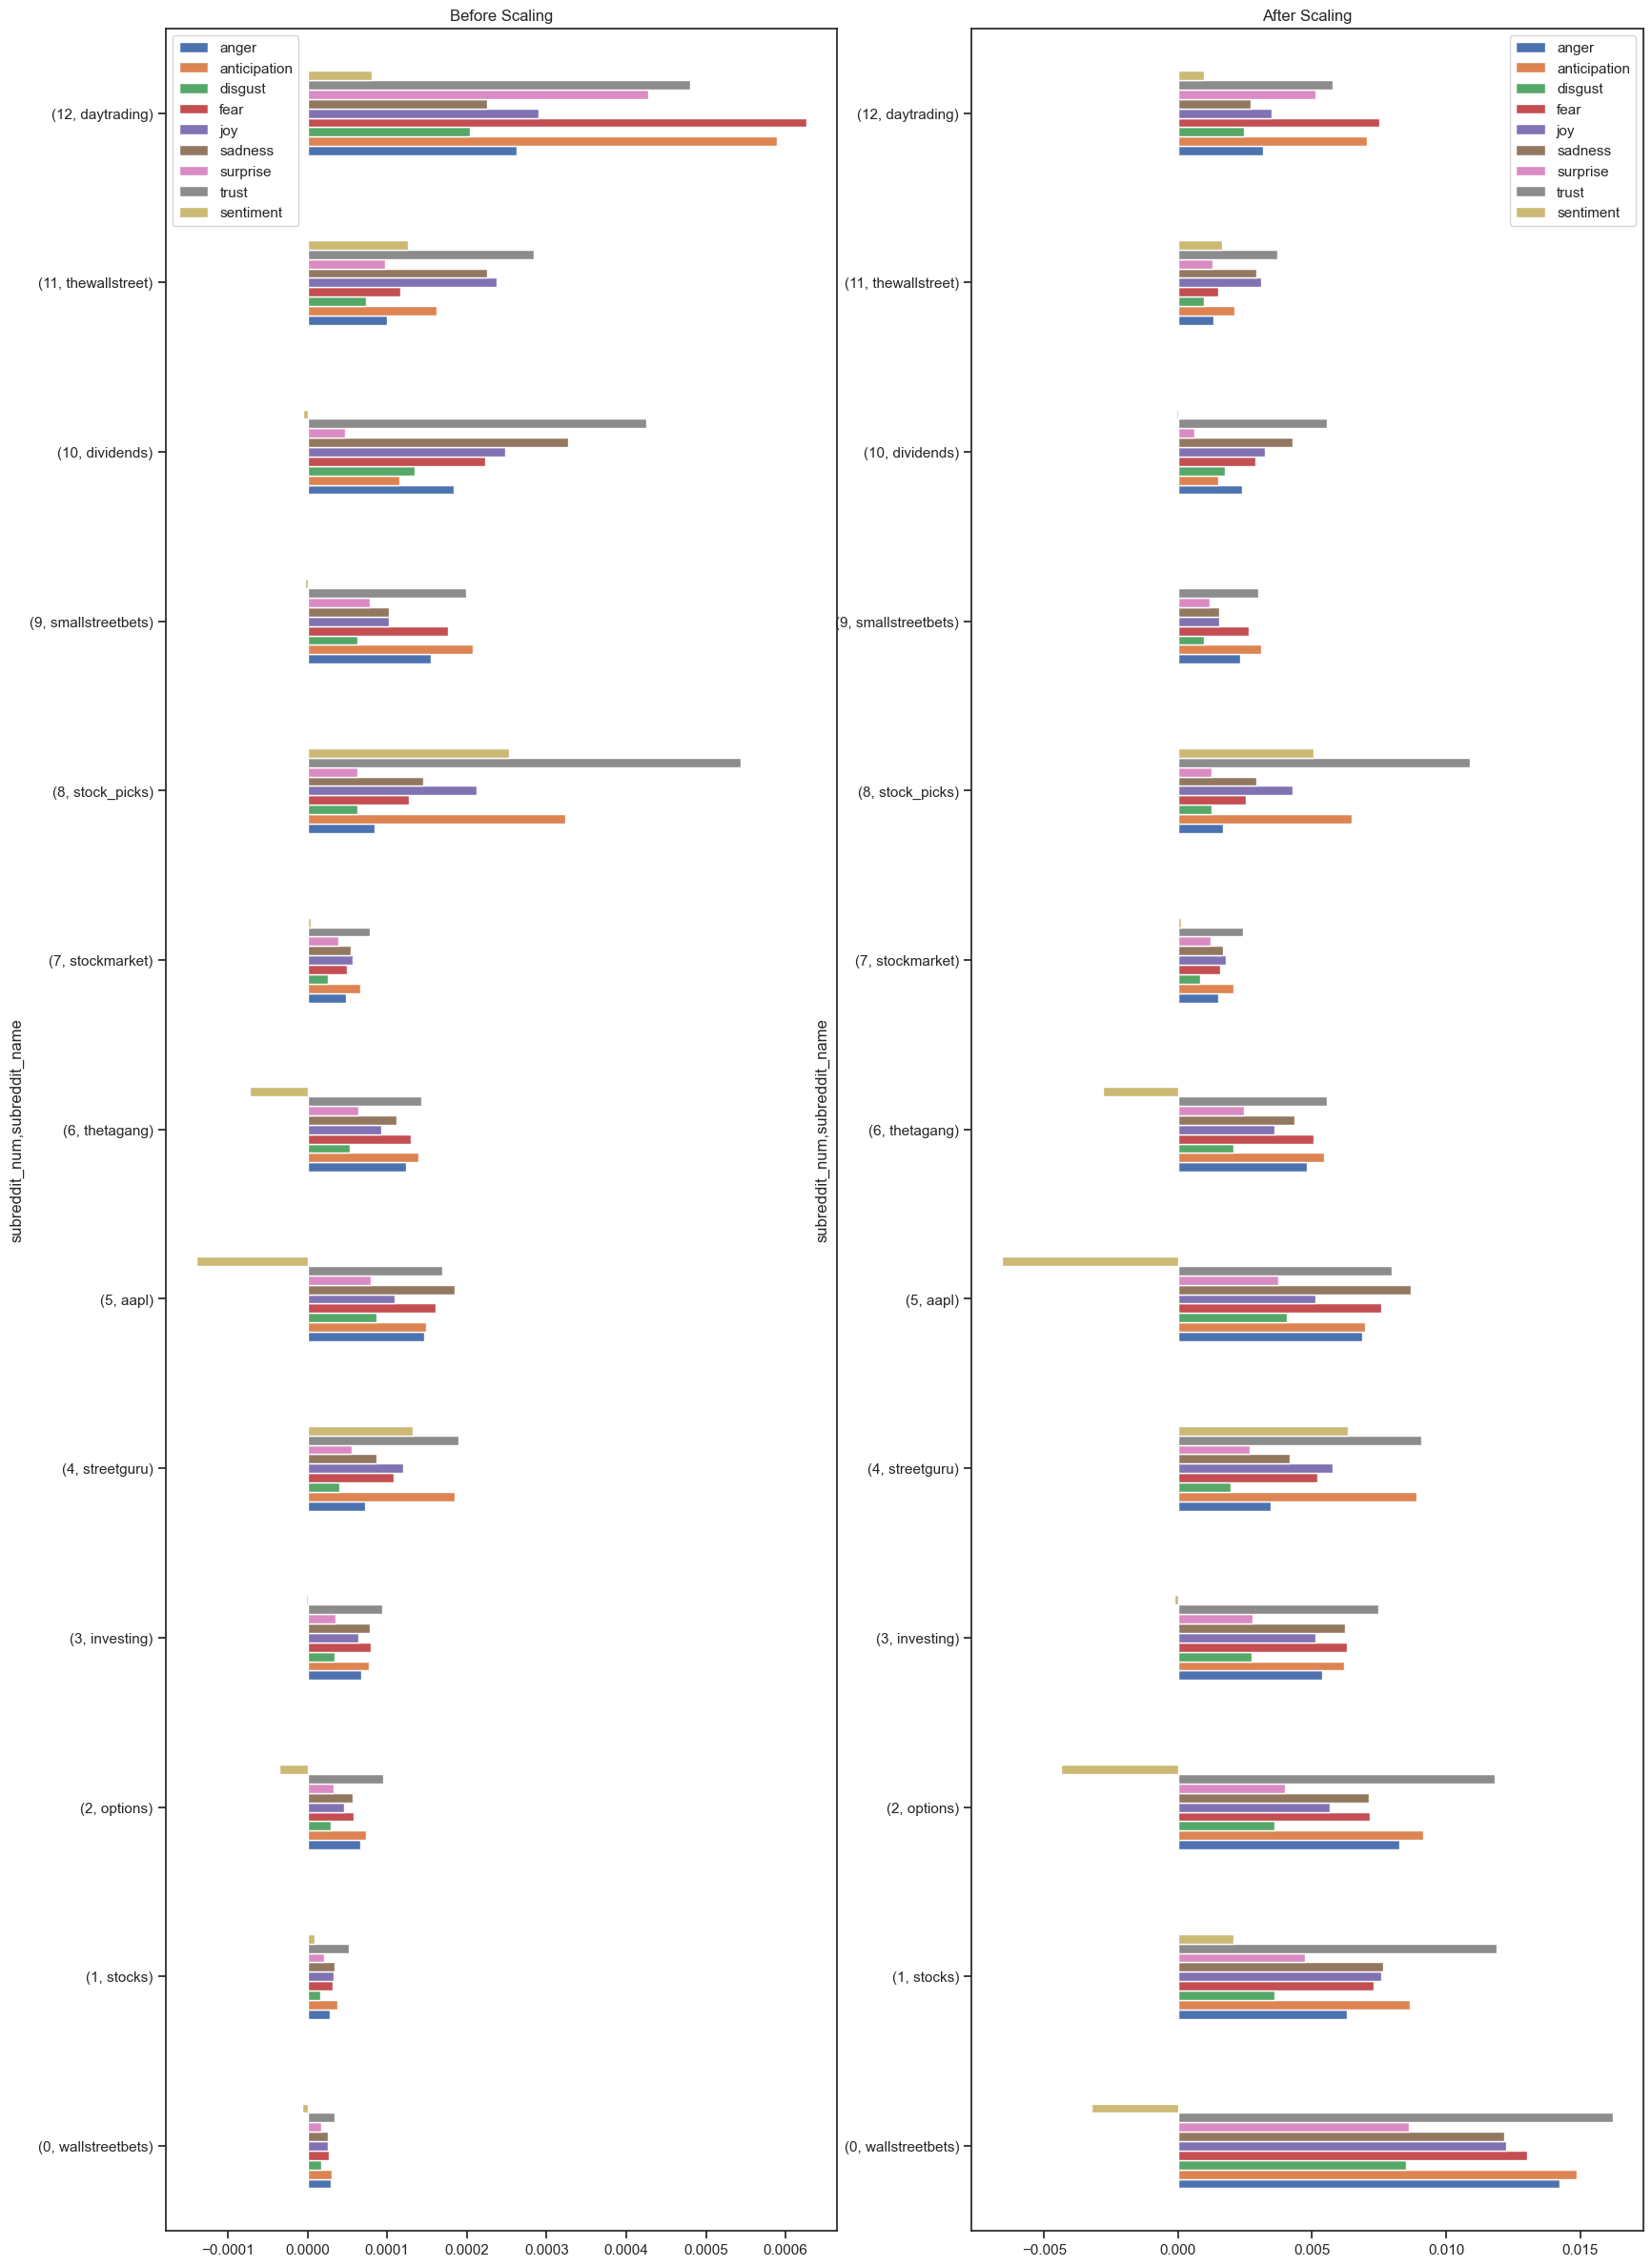

In [44]:
# Plot Sentiment Across Subreddits

LIB_DOC_SENT = pd.merge(DOC_SENT, LIB.set_index('subreddit_num'), left_index=True, right_index=True)
LIB_DOC_SENT.reset_index(inplace=True)
LIB_DOC_SENT.set_index(['subreddit_num','subreddit_name'], inplace=True)

# Plot emotion values by 
fig, axs = plt.subplots(1, 2, figsize=(20, 30))

# Plot before scaling
LIB_DOC_SENT[emo_cols].plot.barh(ax=axs[0])
axs[0].set_title('Before Scaling')

# Scale emotions by number of posts. This gives us the average sentiment of each post.
LIB_DOC_SENT[emo_cols[:-1]] = LIB_DOC_SENT[emo_cols[:-1]]*LIB_DOC_SENT['num_posts']
LIB_DOC_SENT['sentiment'] = LIB_DOC_SENT['sentiment']*LIB_DOC_SENT['num_posts']

# Plot after scaling
LIB_DOC_SENT[emo_cols].plot.barh(ax=axs[1])
axs[1].set_title('After Scaling')

# Show plots
plt.show()

## Word2Vec

### VOCAB_W2V

In [45]:
# Word2Vec parameters

w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, 
    workers = 4
)

In [46]:
# Subet CORPUS to nouns and use SUBREDDIT bag

BAG = SUBREDDIT
docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]

In [47]:
# Create Word2Vec vectors

VOCAB_W2V = word2vec.Word2Vec(docs, **w2v_params)
VOCAB_W2V.wv.vectors

array([[-0.00915999, -0.02049271,  0.10496279, ..., -0.01190429,
         0.19360171,  0.21756975],
       [-0.03557171, -0.10058819,  0.1662441 , ...,  0.00799049,
         0.06330702,  0.19607711],
       [-0.02628263, -0.08399609,  0.15837876, ...,  0.00397851,
         0.09472141,  0.20666374],
       ...,
       [-0.01578798, -0.05746952,  0.11484008, ...,  0.00058432,
         0.06417095,  0.1426851 ],
       [-0.01219746, -0.05276071,  0.11685503, ...,  0.00427129,
         0.0729943 ,  0.15025815],
       [-0.0125198 , -0.05707601,  0.11414857, ...,  0.00824207,
         0.06173754,  0.1417541 ]], dtype=float32)

In [48]:
# Extract Word2Vec vectors to VOCAB_W2V table 

def get_vector(row):
    w = row.name
    try:
        vec = VOCAB_W2V.wv[w]
    except KeyError as e:
        vec = None
    return vec

VOCAB_W2V = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
VOCAB_W2V.head()

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
term_str,,,,,,,,,,,,,,,,,,,,,
1,-0.006564,-0.061857,0.142511,0.081407,-0.032934,-0.145035,-0.206538,0.011588,-0.104307,-0.117669,...,-0.177168,0.161630,0.091766,0.077347,0.055221,-0.161722,0.112808,0.004403,0.124922,0.200178
10,-0.014942,-0.065983,0.162568,0.088899,-0.028536,-0.153214,-0.236447,0.003862,-0.108180,-0.130561,...,-0.193148,0.160274,0.100494,0.088423,0.055626,-0.177082,0.116823,-0.002813,0.130447,0.220245
100,-0.026898,-0.081539,0.168488,0.097650,0.015790,-0.135296,-0.208923,-0.005998,-0.100309,-0.134263,...,-0.185928,0.166200,0.084803,0.077406,0.057078,-0.176333,0.121392,0.011787,0.090932,0.212676
11,-0.014545,-0.059268,0.132435,0.071648,-0.026857,-0.122028,-0.183435,0.014051,-0.086819,-0.105362,...,-0.148489,0.135759,0.083687,0.066452,0.045459,-0.148548,0.101297,-0.002047,0.106648,0.176761
12,0.004762,-0.041882,0.130110,0.063038,-0.074762,-0.145922,-0.209235,0.055113,-0.094260,-0.093737,...,-0.158346,0.142692,0.109679,0.066470,0.061925,-0.183425,0.114037,-0.001187,0.161445,0.196804


### Word2vec tSNE Plot

In [49]:
# Apply TSNE Model to VOCAB_W2V

tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(VOCAB_W2V.to_numpy())
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=VOCAB_W2V.index)
TSNE.head()

,x,y
term_str,,
1,12.617876,-6.430026
10,13.482750,-8.324476
100,-6.596267,-8.284508
11,8.691350,5.427051
12,19.355124,-5.588365


In [50]:
# Join TSNE Model to VOCAB

TSNE.join(VOCAB, how='left')

,x,y,n,p,i,max_pos,max_pos_group,stop,porter_stem,dfidf
term_str,,,,,,,,,,
1,12.617876,-6.430026,260,0.001544,9.338659,CD,CD,0,1,0.000000
10,13.482750,-8.324476,205,0.001218,9.681547,CD,CD,0,10,2.651089
100,-6.596267,-8.284508,103,0.000612,10.674527,CD,CD,0,100,2.651089
11,8.691350,5.427051,88,0.000523,10.901595,CD,CD,0,11,4.774632
12,19.355124,-5.588365,172,0.001022,9.934762,CD,CD,0,12,2.651089
...,...,...,...,...,...,...,...,...,...,...
yesterday,6.821717,-1.095428,102,0.000606,10.688602,NN,NN,0,yesterday,4.774632
yet,-0.509901,5.984750,70,0.000416,11.231744,RB,RB,0,yet,3.785116
you,-25.296700,-9.729656,1000,0.005940,7.395243,PRP,PR,1,you,0.000000


In [51]:
# Plot Word2Vec TSNE Plot

X = TSNE.join(VOCAB, how='left')
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos_group', 
           hover_name='term_str',          
           size='dfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=10, family='Arial'),
                textposition='top center')

## Riffs

### Riff 1: Hierarchical Cluster (Subreddit Level with TFIDF)

In [52]:
# Define L2 Regularization
L2 = TFIDF_L2.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

In [53]:
# Pair TFIDF_L2 Together by SUBREDDIT

PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([TFIDF_L2.index, TFIDF_L2.index], names=['subreddit_id_a', 'subreddit_id_b'])).reset_index()
PAIRS = PAIRS[PAIRS['subreddit_id_a'] < PAIRS['subreddit_id_b']].set_index(['subreddit_id_a', 'subreddit_id_b'])

In [54]:
# Calculate Distances Between Pairs
 
PAIRS['cityblock'] = pdist(TFIDF_L2, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF_L2, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF_L2, 'cosine')

In [55]:
# Add LIB information to TFIDF_L2 

TFIDF_L2 = TFIDF_L2.merge(LIB[['subreddit_num', 'subreddit_name']], left_index=True, right_on='subreddit_num')
TFIDF_L2 = TFIDF_L2.set_index(['subreddit_num', 'subreddit_name'])

In [56]:
# Define Hierarchical Clustering Function

def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(5, 5)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = TFIDF_L2.index
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

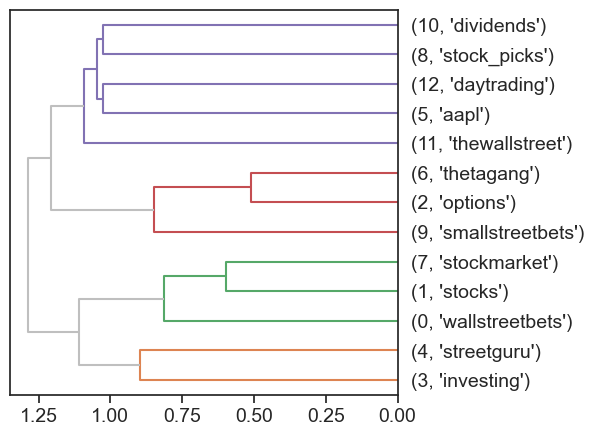

In [59]:
# Plot Hierarchical Clusters

hac(PAIRS.cosine, color_thresh=PAIRS.cosine.median())

### Riff 2: Sentiment/Emotions Over Time

In [60]:
# Recreate CORPUS to include the Post Date
 
paragraphs = pd.DataFrame()
for subreddit_num in LIB['subreddit_num']:
    subreddit_name = LIB['subreddit_name'][subreddit_num]
    subset = data[data['subreddit_name']==subreddit_name].copy()
    subset.sort_values(by=['post_date'], ascending=True, inplace=True)
    subset.reset_index(inplace=True)
    subset['post_num'] = range(len(subset))
    subset['subreddit_num'] = subreddit_num
    paragraph = subset['post_text'].str.split('\n\n', expand=True).stack().to_frame('paragraph')
    paragraph['subreddit_num'] = subreddit_num
    paragraph.index.names = ['post_num','paragraph_num']
    paragraph.reset_index(inplace=True)
    paragraph = pd.merge(paragraph, subset[['post_num', 'post_date']], how='left', on='post_num')
    paragraph.set_index(['subreddit_num', 'post_num','paragraph_num'], inplace=True)
    paragraphs = pd.concat([paragraphs, paragraph])

sentences = paragraphs['paragraph'].str.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s+', expand=True).stack().to_frame('sentence_str')
sentences.index.names = ['subreddit_num', 'post_num', 'paragraph_num', 'sentence_num']
CORPUS_TIME = sentences['sentence_str'].str.split(expand=True).stack().to_frame('token_str')
CORPUS_TIME = CORPUS_TIME[~CORPUS_TIME['token_str'].str.contains('http')]
custom_delimiters = r'[/|*+-]'
CORPUS_TIME['token_str'] = CORPUS_TIME['token_str'].str.split(custom_delimiters)
CORPUS_TIME = CORPUS_TIME.explode('token_str')
CORPUS_TIME['token_str'] = CORPUS_TIME['token_str'].str.replace('aapl', 'apple', case=False)
CORPUS_TIME['token_str'] = CORPUS_TIME['token_str'].str.replace('apples', 'apple', case=False)
CORPUS_TIME['token_str'] = CORPUS_TIME['token_str'].str.replace("apple's", 'apple', case=False)
CORPUS_TIME['term_str'] = CORPUS_TIME.token_str.str.replace(r'\W+', '', regex=True).str.lower()
CORPUS_TIME = CORPUS_TIME[(CORPUS_TIME['term_str'] != '') & (CORPUS_TIME['term_str'].str.strip('_') != '')] 
CORPUS_TIME = CORPUS_TIME[CORPUS_TIME['term_str'].str.strip().astype(bool)]
CORPUS_TIME.index.names = ['subreddit_num', 'post_num', 'paragraph_num', 'sentence_num', 'token_num']

CORPUS_TIME = pd.merge(CORPUS_TIME, paragraphs[['post_date']], how='left', left_index=True, right_index=True)
CORPUS_TIME['year_month'] = CORPUS_TIME['post_date'].dt.to_period('M')
CORPUS_TIME.head()

token_str  \
subreddit_num post_num paragraph_num sentence_num token_num              
0             0        0             0            0                 1)   
                                                  1              Apple   
                                                  2          announces   
                                                  3           earnings   
                                                  4            January   

                                                              term_str  \
subreddit_num post_num paragraph_num sentence_num token_num              
0             0        0             0            0                  1   
                                                  1              apple   
                                                  2          announces   
                                                  3           earnings   
                                                  4            january   

                                                                      post_date  \
subreddit_num post_num paragraph_num sentence_num token_num                       
0             0        0             0            0         2017-01-07 20:43:28   
                                                  1         2017-01-07 20:43:28   
                                                  2         2017-01-07 20:43:28   
                                                  3         2017-01-07 20:43:28   
                                                  4         2017-01-07 20:43:28   

                                                            year_month  
subreddit_num post_num paragraph_num sentence_num token_num             
0             0        0             0            0            2017-01  
                                                  1            2017-01  
                                                  2            2017-01  
                                                  3            2017-01  
                                                  4            2017-01

In [61]:
# Rereate BOW with POST 

CORPUS_noindex = CORPUS_TIME.reset_index()
BOW_post = bow(corpus=CORPUS_noindex, bag='year_month')
BOW_post = BOW_post.merge(TFIDF_stacked,left_index=True,right_index=True)
BOW_post.reset_index(inplace=True)

In [63]:
# Create VOCAB sentiment table

VOCAB_SENT = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)

In [64]:
# Combine VOCAB sentiment table with BOW

emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
BOW_SENT2 = BOW_post.join(VOCAB_SENT[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()
for col in emo_cols:
    BOW_SENT2[col] = BOW_SENT2[col] * BOW_SENT2.tfidf
BOW_SENT2.head()

,year_month,term_str,subreddit_num,n,tfidf,max_pos,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
208,2016-11,bad,0,1,0.000290,JJ,0.000290,0.0,0.000290,0.000290,0.0,0.000290,0.0,0.0,-0.000290
209,2016-11,bad,1,1,0.000271,JJ,0.000271,0.0,0.000271,0.000271,0.0,0.000271,0.0,0.0,-0.000271
210,2016-11,bad,2,1,0.000235,JJ,0.000235,0.0,0.000235,0.000235,0.0,0.000235,0.0,0.0,-0.000235
211,2016-11,bad,3,1,0.000264,JJ,0.000264,0.0,0.000264,0.000264,0.0,0.000264,0.0,0.0,-0.000264
212,2016-11,bad,4,1,0.000000,JJ,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.000000


In [65]:
# Use Year_Month as Index

MONTH_SENT = BOW_SENT2.reset_index()
MONTH_SENT = MONTH_SENT.groupby('year_month')[emo_cols].mean()
MONTH_SENT.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
year_month,,,,,,,,,
2016-11,0.000036,0.000045,0.000019,0.000036,0.000027,0.000026,0.000000,0.000064,0.000063
2017-01,0.000031,0.000047,0.000014,0.000025,0.000031,0.000031,0.000016,0.000057,-0.000005
2017-02,0.000030,0.000078,0.000014,0.000022,0.000051,0.000020,0.000012,0.000093,0.000033
2017-03,0.000028,0.000060,0.000004,0.000020,0.000029,0.000011,0.000013,0.000054,0.000028
2017-04,0.000019,0.000137,0.000030,0.000020,0.000020,0.000030,0.000002,0.000085,0.000044


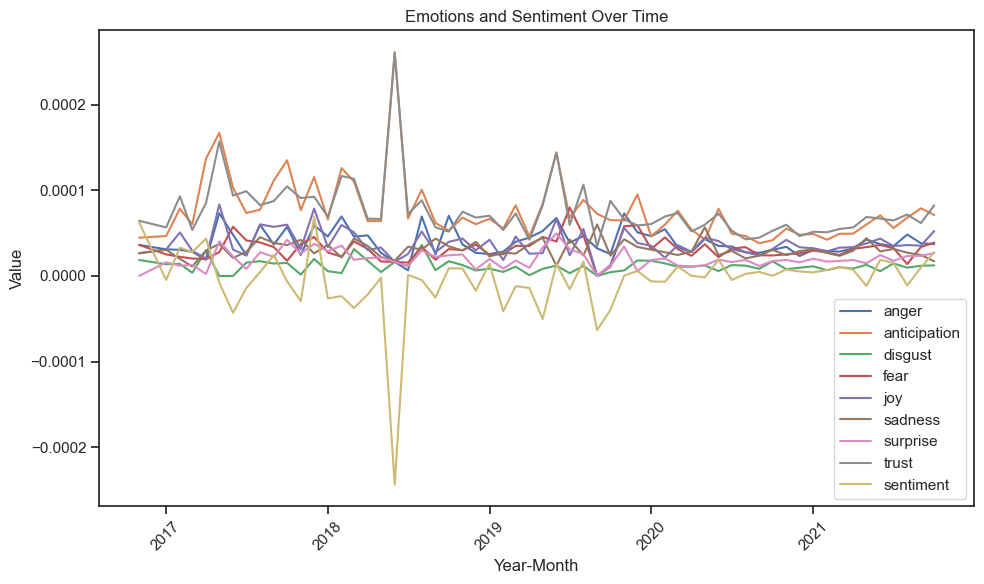

In [66]:
# Plot Sentiment and Emotion Over Time

MONTH_SENT.reset_index(inplace=True)
MONTH_SENT['year_month'] = MONTH_SENT['year_month'].dt.to_timestamp()

plt.figure(figsize=(10, 6))

for emotion in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'sentiment']:
    plt.plot(MONTH_SENT['year_month'], MONTH_SENT[emotion], label=emotion)

plt.xlabel('Year-Month')
plt.ylabel('Value')
plt.title('Emotions and Sentiment Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed


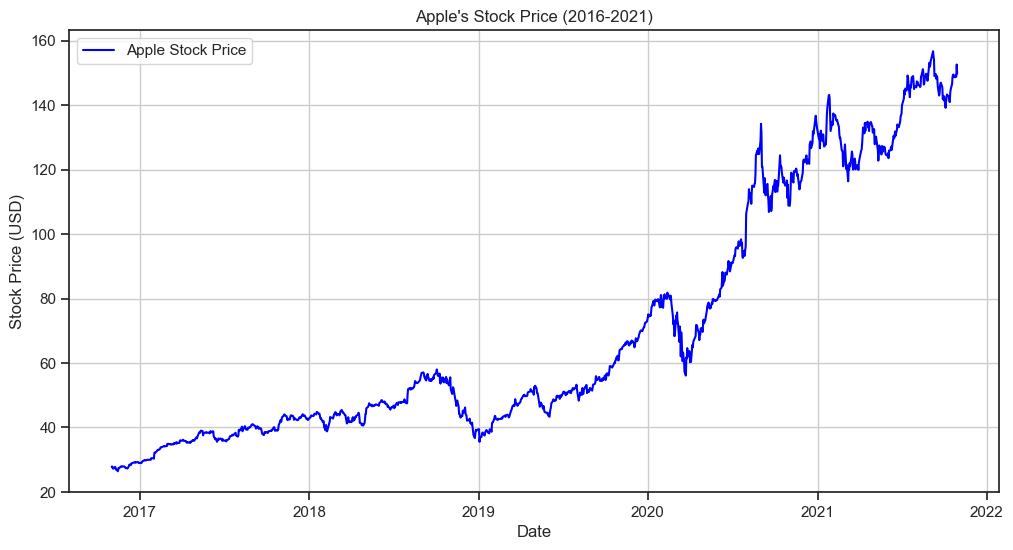

In [67]:
# Fetch historical stock data for Apple from 2016 to 2021

apple_stock = yf.download('AAPL', start='2016-11-01', end='2021-11-01')

plt.figure(figsize=(12, 6))
plt.plot(apple_stock['Close'], label='Apple Stock Price', color='blue')
plt.title("Apple's Stock Price (2016-2021)")
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Riff 3: Hierarchical Cluster (Word Level with W2V)

In [68]:
# Define Hierarchical Clustering Class

class HAC:
    """This class takes an arbitrary vector space and represents it 
    as a hierarhical agglomerative cluster tree. The number of observations
    should be sufficiently small to allow being plotted."""

    w:int = 10
    labelsize:int = 14
    orientation:str = 'left'
    sim_metric:str = 'cosine' 
    tree_method:str = 'ward'
    norm:str = 'l2' 
    
    def __init__(self, M, labels=None):
        self.M = M
        self.h = M.shape[0]
        if labels:
            self.labels = labels            
        else:
            self.labels = M.index.tolist()

    def get_sims(self):
        self.SIMS = pdist(normalize(self.M, norm=self.norm), metric=self.sim_metric)

    def get_tree(self):
        self.TREE = sch.linkage(self.SIMS, method=self.tree_method)        
        
    def plot_tree(self):
        plt.figure()
        fig, axes = plt.subplots(figsize=(self.w, self.h / 3))
        dendrogram = sch.dendrogram(self.TREE, labels=self.labels, orientation=self.orientation);
        plt.tick_params(axis='both', which='major', labelsize=self.labelsize)
        
    def plot(self):
        self.get_sims()
        self.get_tree()
        self.plot_tree()

<Figure size 640x480 with 0 Axes>

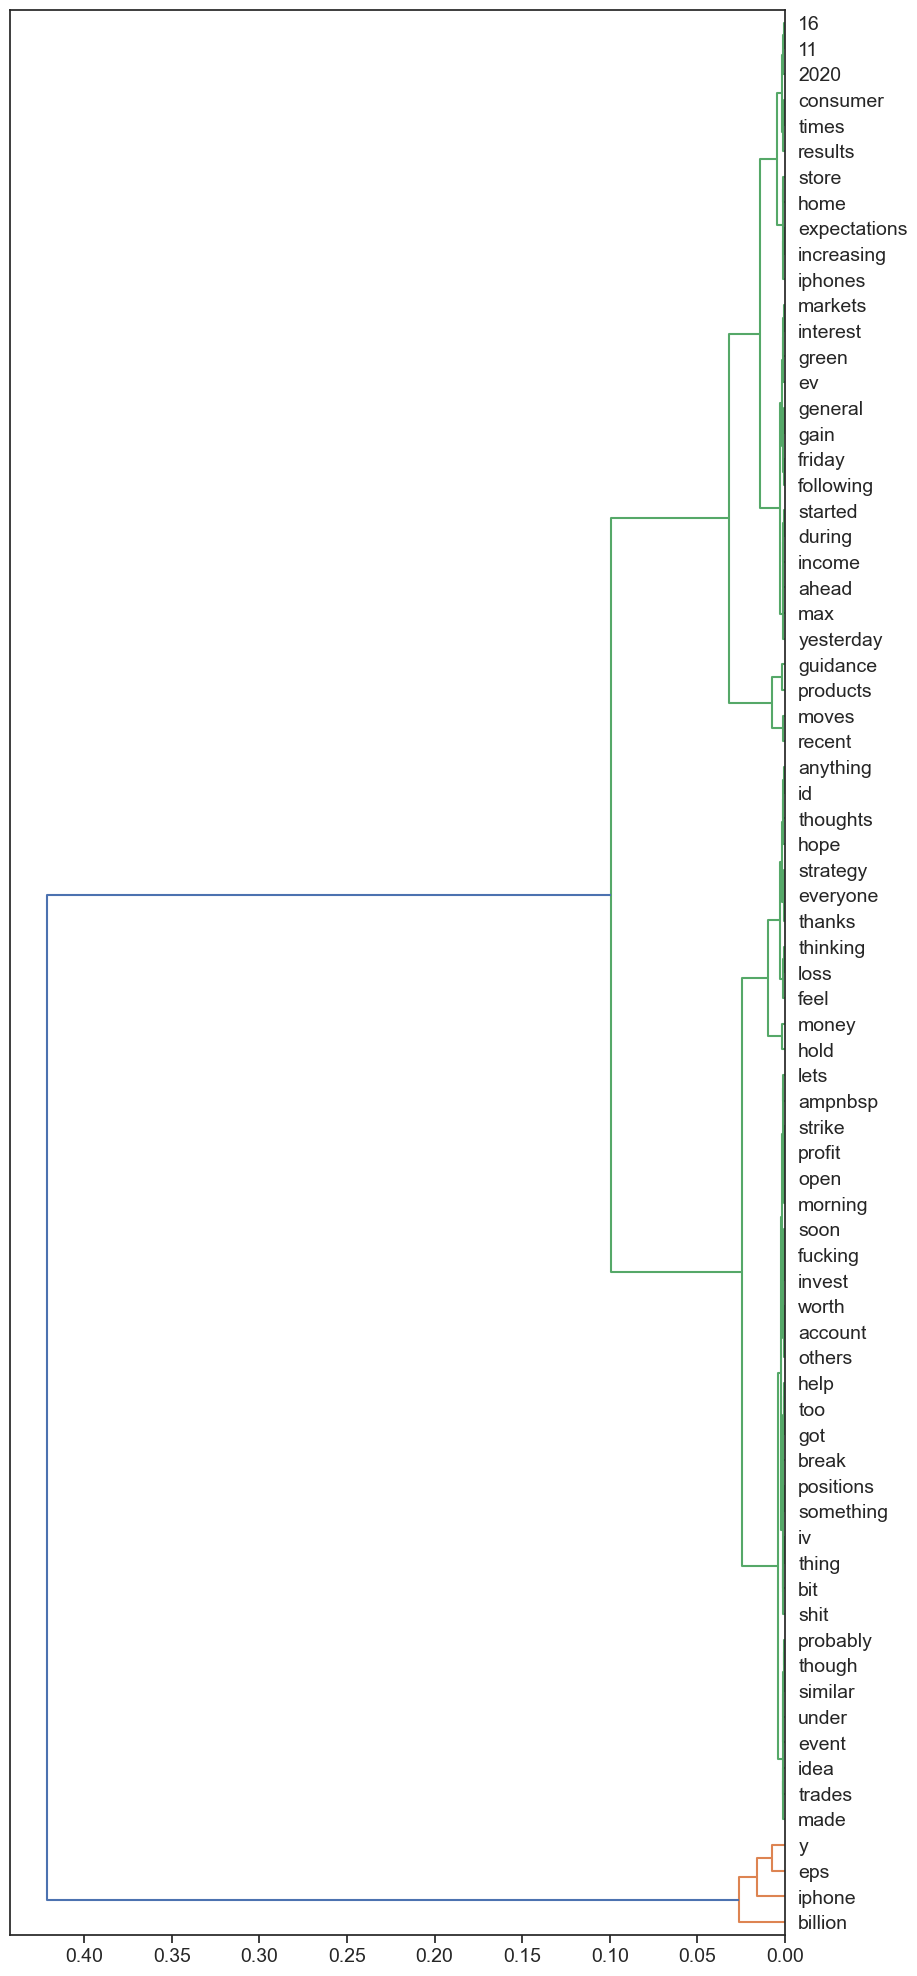

In [80]:
# Plot Hierarchical Cluster of Word2Vec Representation of VOCAB
# Subset VOCAB to words where DFIDF is greater than the mean DFIDF

VOCAB_subset = VOCAB[VOCAB['dfidf']>=VOCAB['dfidf'].mean()]
WV2 = VOCAB_W2V.join(VOCAB.max_pos)
WV2 = WV2[WV2.index.isin(VOCAB_subset.index)]
WV2 = WV2[~WV2.max_pos.str.match(r"NNPS?")].iloc[:, :-1]
HAC(WV2.sample(75)).plot()

## Save Dataframes

In [94]:
dataframes = [LIB, CORPUS, VOCAB, BOW, DTM, DFIDF, TFIDF, TFIDF_L2, COMPS, DCM, LOADINGS, THETA, PHI, TOPICS, PHI_COMPS, PHI_LOADINGS, PHI_DCM, VOCAB_SENT, BOW_SENT, DOC_SENT, LIB_DOC_SENT, VOCAB_W2V, TSNE]

names = ["LIB", "CORPUS", "VOCAB", "BOW", "DTM", "DFIDF", "TFIDF", "TFIDF_L2", "COMPS", "DCM", "LOADINGS", "THETA", "PHI", "TOPICS", "PHI_COMPS", "PHI_LOADINGS", "PHI_DCM", "VOCAB_SENT", "BOW_SENT", "DOC_SENT", "LIB_DOC_SENT", "VOCAB_W2V", "TSNE"]

for df, name in zip(dataframes, names):
    df.to_csv(f"{name}.csv", index=True)